# Analysis of brainstorming transcript : divergent processes
The following is an ongoing analysis of transcripts from 18 teams; 9 of the teams performed what is called "free" brainstorming
The remaining 9 performed an alternating divergent-convergent process. The transcript for each team is split into its divergent and convergent components. 
This analysis concerns only the divergent components.

## Code credits
A lot of this code is thanks to Moses Boudourides, Sergios Lenis & Pantelis Vikatos. Their version (large snippets of which are used here, especially in commonality and co-occurrence computations) can be seen at:
http://mboudour.github.io/2016/03/22/Clinton-Sanders-Word-Nets.html

In [2]:
# Get all imports out of the way
import nltk
from nltk.corpus import wordnet as wn
from nltk.corpus import wordnet_ic
from nltk.corpus import stopwords
from nltk.corpus.reader.wordnet import information_content
from nltk.tokenize import sent_tokenize
import itertools
import codecs
import re
import pprint as pp
import operator
from collections import OrderedDict
from collections import Counter
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

## Step 1: Read Files
We first read the transcript text files. Each team's transcript is split into sections of
"divergent" processes (idea generation) and of "convergent" processes (idea evaluation/selection).
For this analysis, we will only look at the divergent processes. The goal is to understand what 
concepts are common between the two groups (Free and D-C), and what concepts are unique to each group.

In [3]:
# Locations of input files. These files have been anonymized, and the files themselves will not be available
# in this folder, to preserve the privacy of the teams.
textPathFree = "../../../private/brainstorming_viz_data/free_group/"
textPathDC = "../../../private/brainstorming_viz_data/d-c_group/"

# Teamwise transcript (of divergent processes) of the "Free Brainstorming" group
fileNamesFree = ['teamA_part1_divergent.txt',
                 'teamB_part1_divergent.txt',
                 'teamC_part1_divergent.txt',
                 'teamD_part1_divergent.txt',
                 'teamE_part1_divergent.txt',
                 'teamF_part1_divergent.txt',
                 'teamG_part1_divergent.txt',
                 'teamH_part1_divergent.txt',
                 'teamI_part1_divergent.txt']

# Teamwise transcript (of divergent processes) of the "Divergent-Convergent (D-C) Brainstorming" group
fileNamesDC = ['teamJ_part1_divergent.txt',
               'teamJ_part3_divergent.txt',
               'teamK_part1_divergent.txt',
               'teamK_part3_divergent.txt',
               'teamL_part1_divergent.txt',
               'teamL_part3_divergent.txt',
               'teamM_part1_divergent.txt',
               'teamM_part2_3_convergent_divergent.txt',
               'teamN_part1_divergent.txt',
               'teamN_part3_divergent.txt',
               'teamO_part1_divergent.txt',
               'teamO_part2_3_conv_div.txt',
               'teamP_part1_divergent.txt',
               'teamP_part3_divergent.txt',
               'teamQ_part1_divergent.txt',
               'teamQ_part3_4_div_conv.txt',
               'teamR_part1_divergent.txt',
               'teamR_part3_divergent.txt'] 

def openFiles(fileNamesList, filePath):
    # Given a list of file names and a path for the files, returns a
    # list of file objects
    fObjList = []
    for fileName in fileNamesList:
        fObj = open(filePath + fileName, 'r', encoding='utf8')
        fObjList.append(fObj)
    return fObjList

filesListFree = openFiles(fileNamesFree, textPathFree)
filesListDC = openFiles(fileNamesDC, textPathDC)

## Step 2: File processing
To avoid processing errors, we first remove all non-UTF characters in the text (such as distinct opening and closing quotes)
and replace them with corresponding UTF characters.
These transcripts also come with the transcriber's observations, such as [laughter], or [silent]. We remove all such observations so that we are only looking at team members' speech.

In [4]:
# Some of these files have non-UTF characters that may need to be removed.
def removeSpecials(filesList):
    # Remove some incompatible unicode characters such as distinct
    # opening and closing quotes, ellipsis etc.
    # Also finally converts all text to lowercase
    outString = ''
    for inFile in filesList:
        # print("reading file",inFile.name.split("/")[-1], "...", end="")
        temp = inFile.read()
        subsFileQuotes = re.sub(u"(\u2018|\u2019)", "'", temp)
        subsFileDQuotes = re.sub(u'(\u201c|\u201d)', '"', subsFileQuotes)
        subsFileEllipsis = re.sub(u"\u2026", "...", subsFileDQuotes)
        outString += subsFileEllipsis
        # print("done.")
    return outString.lower()

group1_divergent_raw = removeSpecials(filesListFree)
group2_divergent_raw = removeSpecials(filesListDC)

In [5]:
# These files have the transcriber's observations like [laughter], [silent], [cross-talk] etc.
# These may throw off the text analysis, so we remove them. These are typically within parantheses,
# so we can remove everything between these parantheses.

def removeObservations(test_str) :
    # removes all text within parantheses
    # these are usually observations by the transcriber
    # and thus should not be considered in content analysis
    # code from http://stackoverflow.com/questions/14596884/remove-text-between-and-in-python
    ret = ''
    skip1c = 0
    skip2c = 0
    squareparen = 0
    for i in test_str:
        if i == '[':
            skip1c += 1
            squareparen += 1
        elif i == '(':
            skip2c += 1
        elif i == ']' and skip1c > 0:
            skip1c -= 1
        elif i == ')'and skip2c > 0:
            skip2c -= 1
        elif skip1c == 0 and skip2c == 0:
            ret += i
    print("Number of observations removed", str(squareparen))
    return ret

group1_divergent = removeObservations(group1_divergent_raw)
group2_divergent = removeObservations(group2_divergent_raw)

Number of observations removed 1128
Number of observations removed 657


## Step 3: Tokenizing, stop word removal, and Lemmatization
We split the text from the transcripts into individual words. Of these, we remove "stop words" -- common words that add little meaning, such as articles, pronouns, prepositions etc. We then "lemmatize" the resulting words so that words such as "short", "shorter", and "shortest" are treated the same (short), and words with different tenses, singular/plural forms etc. are also treated the same.

In [6]:
# Split the file into words using a tokenizer
# Also name the variables a little more meaningfully
freeWords = nltk.word_tokenize(group1_divergent) 
DCWords = nltk.word_tokenize(group2_divergent)

# Remove stop words
freeWordsFiltered = [w for w in freeWords if not w in stopwords.words('english')]
DCWordsFiltered = [w for w in DCWords if not w in stopwords.words('english')]
freeDiff = len(freeWords) - len(freeWordsFiltered)
DCDiff = len(DCWords) - len(DCWordsFiltered)
print(freeDiff, "stop words removed from a total of", len(freeWords),"in the Free group")
print(DCDiff, "stop words removed from a total of", len(DCWords), "in the Divergent-Convergent group")

26911 stop words removed from a total of 64501 in the Free group
21564 stop words removed from a total of 52138 in the Divergent-Convergent group


In [7]:
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
wnL = WordNetLemmatizer()
ps = PorterStemmer()

# Lemmatize the tokenized words. This reduces singular, plural forms to the same form 
# to merge different forms of the same word together.
# to speed things up, remove non-unique words
# freeWordsUnique = list(set(freeWordsFiltered))
# print(len(freeWordsFiltered), "reduced to", len(freeWordsUnique), "unique words in free brainstorming transcript.")
# lemmatize the words
def genLemma(wordList):
    lemmaList = []
    for word in wordList:
        synsets = wn.synsets(word)
        if len(synsets) > 0 :
            synset = synsets[0] # assume most common use of the word
            sName = synset.name().split('.')[0]
            sPos = synset.pos()
            wordLemma = wnL.lemmatize(sName, pos=sPos)
            lemmaList.append(wordLemma)
    return lemmaList
        
            
# freeWordsLemmatized = [wnL.lemmatize(w) for w in freeWordsFiltered]
freeWordsLemmatized = genLemma(freeWordsFiltered)
freeWordsLemmU = list(set(freeWordsLemmatized))
print("Words in the Free Group reduced by lemmatization to", len(freeWordsLemmU))

# NOTE: We choose to not do stemming as the stems cannot be processed by the WordNet library to find infocontent.

# Do the same for the D-C group
# DCWordsUnique = list(set(DCWordsFiltered))
# print(len(DCWordsFiltered), "reduced to", len(DCWordsUnique), "unique words in D-C brainstorming transcript.")
# lemmatize the words
# DCWordsLemmatized = [wnL.lemmatize(w) for w in DCWordsFiltered]
DCWordsLemmatized = genLemma(DCWordsFiltered)
DCWordsLemmU = list(set(DCWordsLemmatized))
print("Words in the D-C Group reduced by lemmatization to", len(DCWordsLemmU))

Words in the Free Group reduced by lemmatization to 2177
Words in the D-C Group reduced by lemmatization to 2137


## Step 4: Partition based on Information Content
As we can see, the resulting list of words is rather large and unmanageable. We "rank" these words based on information content.
Information content is a measure of how important a word is, and it depends on the likelihood of finding a word in a text corpus, i.e.

$$IC(w) = -log(P(w)) $$

After iterating through all the text corpora available in WordNet, we settle on the British National Corpus as most suitable for our dataset, as it has the largest overlap with our dataset.

In [8]:
def getInfoContent(wordList, corpus):
    tokens = []
    icArray = []
    nonicArray = []
    for token in wordList:
        tempNum = 0
        synsets = wn.synsets(token)
        if len(synsets) > 0:
            for synset in synsets:
                if not set([synset.pos()]).intersection(set(['a','s','r'])) :
                    synsetItem = synset
                    tempNum = 1
                    break
            if tempNum == 1:
                infoContent = information_content(synsetItem, corpus)
                icArray.append((token, infoContent))
            else :
                nonicArray.append(token)
    icDict = dict(icArray)
    icTuple = sorted(icDict.items(), key=operator.itemgetter(1),
                     reverse=True)
    return [OrderedDict(icTuple), nonicArray]

corpusName = 'ic-bnc-add1'
ic_corpus = wordnet_ic.ic(corpusName + '.dat')
print("Computing infocontent with ",corpusName," corpus...", end="")
freeGroupProcessed = getInfoContent(freeWordsLemmU, ic_corpus)
DCGroupProcessed = getInfoContent(DCWordsLemmU, ic_corpus)
print("done.")

freeGrpInfoContents = freeGroupProcessed[0]
freeGrpNonInfoContents = freeGroupProcessed[1]
DCGrpInfoContents = DCGroupProcessed[0]
DCGrpNonInfoContents = DCGroupProcessed[1]
freeGrpFrequencies = Counter(freeWordsLemmatized)
DCGrpFrequencies = Counter(DCWordsLemmatized)
print("Number of words in the Free Group that could have infocontent computed:", len(freeGrpInfoContents))
print("Number of words in the D-C Group that could have infocontent computed:", len(DCGrpInfoContents))

# Find words for which infocontent could not be computed


Computing infocontent with  ic-bnc-add1  corpus...done.
Number of words in the Free Group that could have infocontent computed: 1926
Number of words in the D-C Group that could have infocontent computed: 1885


In [9]:
# Partition each group's words into 3 based on infocontent scores
print("Partitioning words based on infocontent values...\n")
freeGroup_top3rd = {}
freeGroup_mid3rd = {}
freeGroup_bottom3rd = {}

maxIC = max(freeGrpInfoContents[max(freeGrpInfoContents, key=freeGrpInfoContents.get)],
            DCGrpInfoContents[max(DCGrpInfoContents, key=DCGrpInfoContents.get)])
ic_top3rdLimit = 12
ic_mid3rdLimit = 8
for key, value in freeGrpInfoContents.items():
    if value >= ic_top3rdLimit :
        freeGroup_top3rd[key] = value
    elif value >=ic_mid3rdLimit :
        freeGroup_mid3rd[key] = value
    else :
        freeGroup_bottom3rd[key] = value
print("Partitioning by infocontent in the Free Group:")
print("Found a total of", len(freeGroup_top3rd), "words with infocontent between", ic_top3rdLimit ,"and", maxIC)
print("Found a total of", len(freeGroup_mid3rd), "words with infocontent between", ic_mid3rdLimit, "and", ic_top3rdLimit)
print("Found a total of", len(freeGroup_bottom3rd), "words with infocontent between 0 and", ic_mid3rdLimit, "\n") 

DCGroup_top3rd = {}
DCGroup_mid3rd = {}
DCGroup_bottom3rd = {}
DCGroup0_5 = {}
for key, value in DCGrpInfoContents.items():
    if value >= ic_top3rdLimit :
        DCGroup_top3rd[key] = value
    elif value >= ic_mid3rdLimit :
        DCGroup_mid3rd[key] = value
    else :
        DCGroup_bottom3rd[key] = value
print("Partitioning by infocontent in the D-C Group:")
print("Found a total of", len(DCGroup_top3rd), "words with infocontent between", ic_top3rdLimit ,"and", maxIC)
print("Found a total of", len(DCGroup_mid3rd), "words with infocontent between", ic_mid3rdLimit, "and", ic_top3rdLimit)
print("Found a total of", len(DCGroup_bottom3rd), "words with infocontent between 0 and", ic_mid3rdLimit, "\n") 


Partitioning words based on infocontent values...

Partitioning by infocontent in the Free Group:
Found a total of 434 words with infocontent between 12 and 1e+300
Found a total of 1125 words with infocontent between 8 and 12
Found a total of 367 words with infocontent between 0 and 8 

Partitioning by infocontent in the D-C Group:
Found a total of 432 words with infocontent between 12 and 1e+300
Found a total of 1101 words with infocontent between 8 and 12
Found a total of 352 words with infocontent between 0 and 8 



## Step 5: Identifying common & unique words
Our overarching question is to identify behavior that is common to both groups (the free brainstorming group and the divergent-convergent brainstorming group), and behavior that is unique to each group. Identifying words common to both groups and words unique to each group is how we approach this transcript analysis.

In [ ]:
topCommon = {}
nottopCommon = {}
freeGrp_top_uncommon = {}
DCGrp_top_uncommon = {}
u=1
print("Computing words common between the two groups with infocontent between", ic_top3rdLimit ,"and", maxIC,"...", end="")
for i in freeGroup_top3rd:
    if i in DCGroup_top3rd:
        topCommon[i] = min(freeGrpFrequencies[i], DCGrpFrequencies[i])
        nottopCommon[i] = (freeGrpFrequencies[i], DCGrpFrequencies[i])
        # dfc.loc[u] = [i, nounFreeGroupSorted[i], nounDCGroupSorted[i]]
        u+=1
    else :
        freeGrp_top_uncommon[i] = freeGrpFrequencies[i]
for i in DCGroup_top3rd:
    if i not in freeGroup_top3rd:
        DCGrp_top_uncommon[i] = DCGrpFrequencies[i]
            
print("Done.")
print("Number of common words found:", len(topCommon))
print("Number of words that unique to the free group:", len(freeGrp_top_uncommon))
print("Number of words that unique to the D-C group:", len(DCGrp_top_uncommon))

midCommon = {}
notmidCommon = {}
freeGrp_mid_uncommon = {}
DCGrp_mid_uncommon = {}
u=1
print("Computing words common between the two groups with infocontent between", ic_mid3rdLimit ,"and", ic_top3rdLimit,"...", end="")
for i in freeGroup_mid3rd:
    if i in DCGroup_mid3rd:
        midCommon[i] = min(freeGrpFrequencies[i], DCGrpFrequencies[i])
        notmidCommon[i] = (freeGrpFrequencies[i], DCGrpFrequencies[i])
        # dfc.loc[u] = [i, nounFreeGroupSorted[i], nounDCGroupSorted[i]]
        u+=1
    else :
        freeGrp_mid_uncommon[i] = freeGrpFrequencies[i]
for i in DCGroup_mid3rd:
    if i not in freeGroup_mid3rd:
        DCGrp_mid_uncommon[i] = DCGrpFrequencies[i]
print("Done.")
print("Number of common words found:", len(midCommon))
print("Number of words that unique to the free group:", len(freeGrp_mid_uncommon))
print("Number of words that unique to the D-C group:", len(DCGrp_mid_uncommon))

bottomCommon = {}
notbottomCommon = {}
freeGrp_bottom_uncommon = {}
DCGrp_bottom_uncommon = {}
u=1
print("Computing words common between the two groups with infocontent between 0 and", ic_mid3rdLimit,"...", end="")
for i in freeGroup_bottom3rd:
    if i in DCGroup_bottom3rd:
        bottomCommon[i] = min(freeGrpFrequencies[i], DCGrpFrequencies[i])
        notbottomCommon[i] = (freeGrpFrequencies[i], DCGrpFrequencies[i])
        # dfc.loc[u] = [i, nounFreeGroupSorted[i], nounDCGroupSorted[i]]
        u+=1
    else :
        freeGrp_bottom_uncommon[i] = freeGrpFrequencies[i]
for i in DCGroup_bottom3rd:
    if i not in freeGroup_bottom3rd:
        DCGrp_bottom_uncommon[i] = DCGrpFrequencies[i]
print("Done.")
print("Number of common words found:", len(bottomCommon))
print("Number of words that unique to the free group:", len(freeGrp_bottom_uncommon))
print("Number of words that unique to the D-C group:", len(DCGrp_bottom_uncommon))

Computing words common between the two groups with infocontent between 12 and 1e+300 ...Done.
Number of common words found: 161
Number of words that unique to the free group: 273
Number of words that unique to the D-C group: 271
Computing words common between the two groups with infocontent between 8 and 12 ...Done.
Number of common words found: 708
Number of words that unique to the free group: 417
Number of words that unique to the D-C group: 393
Computing words common between the two groups with infocontent between 0 and 8 ...Done.
Number of common words found: 280
Number of words that unique to the free group: 87
Number of words that unique to the D-C group: 72


## Step 6: Identify co-occurrences
We go over each sentence in the original dataset and look for word co-occurrences; pairs of words that occur in the same sentence. This helps us draw a concept map for each group's divergent brainstorming transcript data.

### NOTE
In this part of the analysis, we only look at words that are in the top stratum of information content (see results above).

In [ ]:
# Function to count co-occurrences of common noun phrases in sentences
def occurrences(source, terms):
    ALL_sentences=sent_tokenize(source) # creates a list of sentences
    combinations_terms = list(itertools.combinations(terms,2)) # NC2 of terms
    n = len(combinations_terms)
    occurlist = []
    for i in range(1, n):
        for j in ALL_sentences:
            temp = list(combinations_terms[i])
            # Find every combination of term 1 followed by term 2 in
            # term pair (1,2)
            out=re.compile(str(temp[0]) + '(.*?)' + str(temp[1]), 
                           re.DOTALL | re.IGNORECASE).findall(j)
            if out:
                occurlist.append(str(temp[0]) + ' - ' + str(temp[1]))
            # Find every combination of term 2 followed by term 1 in
            # term pair (1,2)
            out2 = re.compile(str(temp[1]) + '(.*?)' + str(temp[0]),
                             re.DOTALL | re.IGNORECASE).findall(j)
            if out2:
                occurlist.append(str(temp[1]) + ' - ' + str(temp[0]))
    occurdict = {}
    # count occurrences of term pairs
    for i in occurlist:
        if i not in occurdict:
            occurdict[i] = 1
        else : 
            occurdict[i] = occurdict[i] + 1
    return occurdict

# Call function to find divergent and convergent terms
freeCooccur_top = occurrences(group1_divergent, topCommon)
DCCooccur_top = occurrences(group2_divergent, topCommon)
print("Number of co-occurrences found in the Free Group:", len(freeCooccur_top))
print("Number of co-occurrences found in the D-C Group:", len(DCCooccur_top))

## Step 7: Plot word co-occurrence for the Free Brainstorming group
We use the data obtained in step 6 to plot a graph of co-occurrences in the "free brainstorming" group.

In [ ]:
# Function to construct a graph of common noun phrases tied by 
# their co-occurrences in sentences of a transcript
def makegraph(occurrences):
    G = nx.Graph()
    weights = []
    for edgs,wt in occurrences.items():
        edg = edgs.split(' - ')
        G.add_edge(edg[0], edg[1], weight=wt)
        G.add_node(edg[0], label=edg[0])
        G.add_node(edg[1], label=edg[1])
        weights.append(wt)
    return [G, weights]

FreeGraphData = makegraph(freeCooccur_top)
DCGraphData = makegraph(DCCooccur_top)
GFree = FreeGraphData[0]
GDC = DCGraphData[0]
FreeEdges = FreeGraphData[1]
DCEdges = DCGraphData[1]

In [ ]:
# Plot graph of common phrases 
from tools import draw_network
%matplotlib inline
pos = nx.spring_layout(GFree, iterations=20)
sstt="The Free Group's wordnet during divergent phase of brainstorming"
possit=draw_network(GFree,sstt,pos=pos,with_edgewidth=True,withLabels=True,
                    labfs=15,valpha=0.2,ealpha=0.3,labelfont=15)

## Step 8: Calculate centralities
The centralities of common words above can be calculated. Here, we look at the following centralities:
NOTE: Most definitions here are from Wikipedia, but need to refine these to the definitions presented in corresponding papers.

#### Betweenness Centrality 
Defined for a node, this is equal to the number of shortest paths from all vertices to all others that pass through that node.

#### Closeness Centrality
This is defined as the reciprocal of the sum of its distances from all other nodes.

#### Degree Centality
This is defined as the number of links incident upon a node.

#### Katz Centrality
Similar to Degree centrality, the Katz centrality measures the number of all nodes that can be connected through a path, while penalizing the contributions of distant nodes.

#### Eigenvector Centrality
This is a measure of the influence of a node in a network. It assigns relative scores to all nodes in the network based on the concept that connections to high-scoring nodes contribute more to the score of the node in question than equal connections to low-scoring nodes.

#### PageRank
Similar to Katz centrality, the pagerank measure has an additional weighting measure that weights edges on their "influence" on the network (insert equation later).

In [ ]:
# Compute centralities of cmmon phrases in the graph of the divergent process
%reload_ext autoreload
%autoreload 1
from tools import draw_centralities_subplots
centrali=draw_centralities_subplots(GFree, pos, withLabels=True,labfs=5, figsi=(15, 15), ealpha=0.15, vals=True)

## 8.1 Generate Table of Centralities
We list the centralities of the words common to both groups, calculated using the above metrics. Remember that this is a shortened list of words, with information content above 12.

In [1]:
# Generate Centralities Table
dfchc=pd.DataFrame()
dfchc.insert(0,'Common Nouns', centrali[list(centrali.keys())[0]].keys())
u=1
for i,k in centrali.items():
    dfchc.insert(u,i,k.values())
dfchc

NameError: name 'pd' is not defined

## Step 9: Identify Communities
Here communities are nothing but partitions that can be made to the network. For details refer "tools.py" in the parent directory. 
Identifying these partitions can help us identify "themes" to each group's transcripts, helping us understand the group's behavior better.

Number of communities of  The Free Group's wordnet during divergent phase of brainstorming  =  7
Community partition of  The Free Group's wordnet during divergent phase of brainstorming :
[['transformer',
  'launcher',
  'till',
  'kangaroo',
  'basketball',
  'chalk',
  'goldberg',
  'balloon',
  'turbine'],
 ['penguin',
  'frisbee',
  'bb',
  'suction',
  'servo',
  'mechanic',
  'parachute',
  'hop',
  'fake',
  'hoop',
  'dart',
  'cherry',
  'glider',
  'quiz',
  'jack-in-the-box',
  'forth',
  'trampoline',
  'up',
  'swivel',
  'roller',
  'drag',
  'flop',
  'battleship',
  'alligator',
  'down'],
 ['dinosaur', 'attache', 'crossbow', 'joust'],
 ['segway',
  'maze',
  'crane',
  'compress',
  'puff',
  'lego',
  'foil',
  'splash',
  'roommate',
  'blowing',
  'skateboard',
  'hippo',
  'whoop',
  'paintball',
  'yea',
  'hover'],
 ['rig',
  'launching',
  'spinning',
  'levitate',
  'bounce',
  'catapult',
  'paddle',
  'buoyancy',
  'magnet',
  'timer'],
 ['jolly', 'rancher'],

C:\Anaconda3\lib\site-packages\matplotlib\collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
C:\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


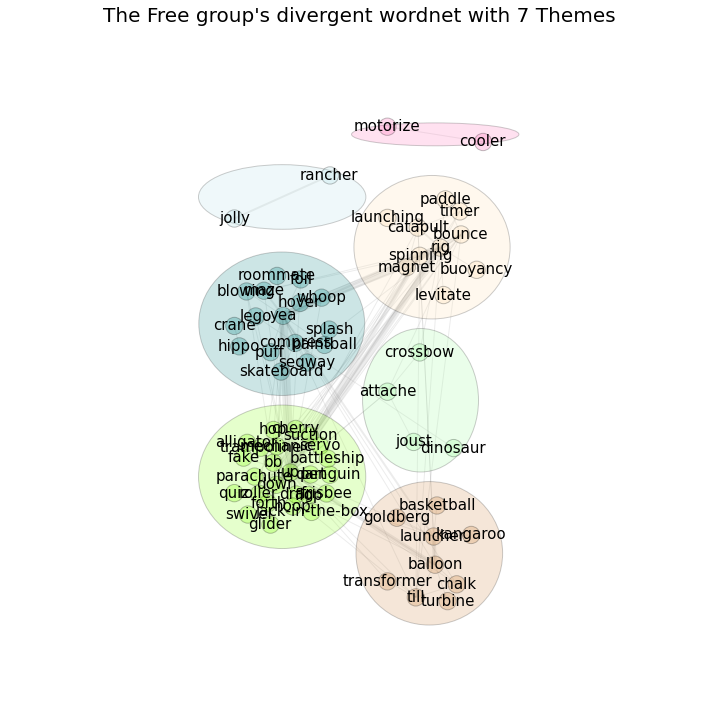

In [21]:
# detecting communities of common phrases
%autoreload 2
from tools import draw_comms, modul_arity, print_communities
part, nodper = print_communities(GFree, sstt)

d=0.8 
dd=0.8
c=1.2
cc=1.4
alpha=0.2
ealpha=0.15
vcc={}

sstta="The Free group's divergent wordnet with "+ str(max(part.values())+1) + " Themes" 
draw_comms(GFree,GFree.nodes(),[],[],[] ,part,part,d,dd,c,cc,alpha,ealpha,nodper,sstta,titlefont=20,labelfont=15,valpha=0.25)

## Step 10: Perform steps 7-9 for the Divergent-Convergent Group

C:\Anaconda3\lib\site-packages\matplotlib\collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
C:\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


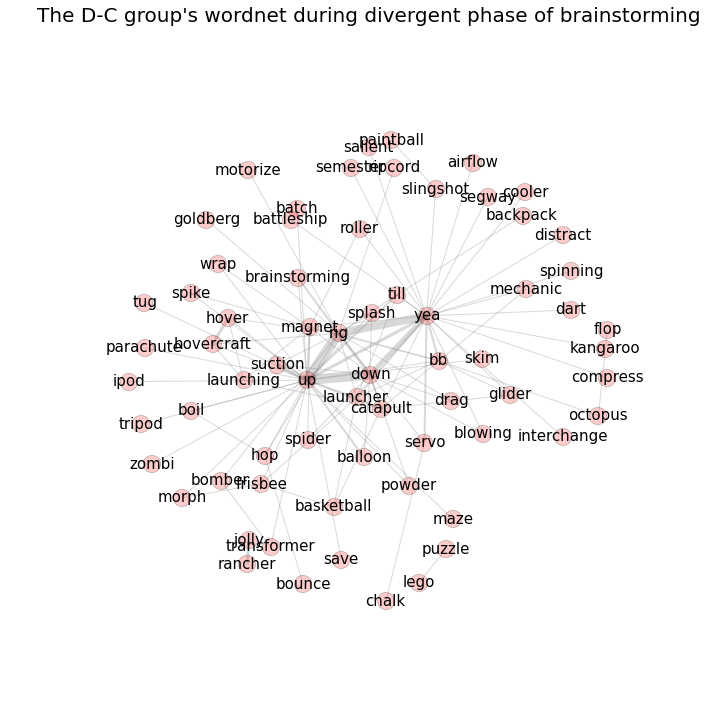

In [102]:
# Plot graph of common phrases in Team A's convergent phase
from tools import draw_network
pos = nx.spring_layout(GDC, iterations=20)
sstt="The D-C group's wordnet during divergent phase of brainstorming"
possit=draw_network(GDC,sstt,pos=pos,with_edgewidth=True,withLabels=True,
                    labfs=15,valpha=0.2,ealpha=0.3,labelfont=15)

C:\Anaconda3\lib\site-packages\matplotlib\collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
C:\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


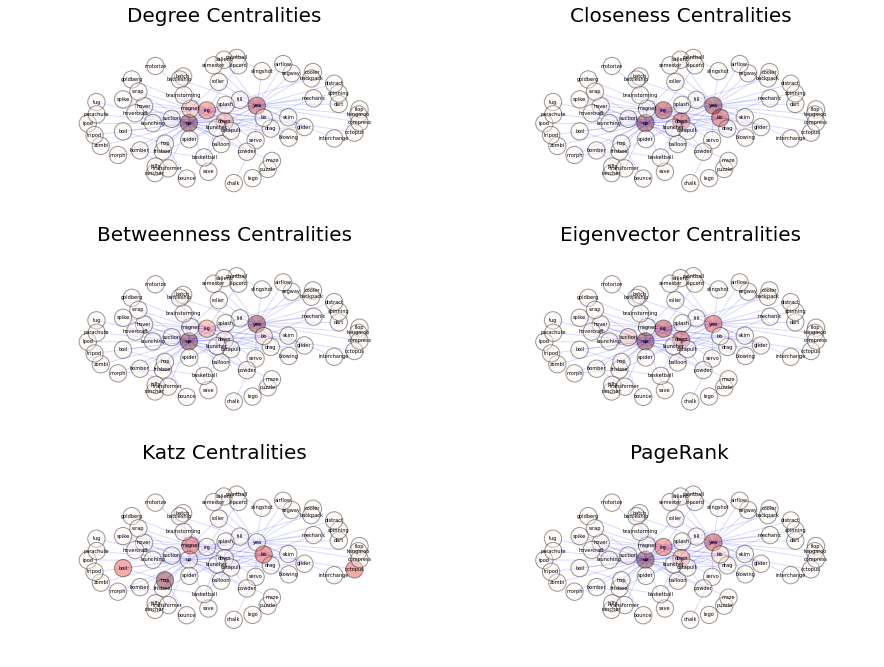

In [103]:
# Compute centralities of cmmon phrases in the graph of the divergent process

from tools import draw_centralities_subplots
centrali=draw_centralities_subplots(GDC, pos, withLabels=True,labfs=5, figsi=(15, 15), ealpha=0.15, vals=True)

Number of communities of  The D-C group's wordnet during divergent phase of brainstorming  =  7
Community partition of  The D-C group's wordnet during divergent phase of brainstorming :
[['servo',
  'paintball',
  'segway',
  'salient',
  'interchange',
  'chalk',
  'cooler',
  'dart',
  'slingshot',
  'spinning',
  'airflow',
  'yea',
  'kangaroo',
  'blowing',
  'semester',
  'distract',
  'battleship',
  'compress'],
 ['batch',
  'up',
  'brainstorming',
  'splash',
  'tug',
  'transformer',
  'parachute',
  'ripcord',
  'drag',
  'maze',
  'save',
  'goldberg',
  'down',
  'motorize',
  'suction',
  'ipod',
  'zombi',
  'balloon',
  'bomber',
  'rig',
  'tripod',
  'powder',
  'skim'],
 ['magnet',
  'hover',
  'launching',
  'wrap',
  'spider',
  'roller',
  'hovercraft',
  'spike'],
 ['octopus',
  'flop',
  'basketball',
  'backpack',
  'till',
  'morph',
  'frisbee',
  'launcher',
  'mechanic',
  'glider',
  'catapult',
  'bb'],
 ['puzzle', 'lego'],
 ['rancher', 'jolly'],
 ['boun

C:\Anaconda3\lib\site-packages\matplotlib\collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
C:\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


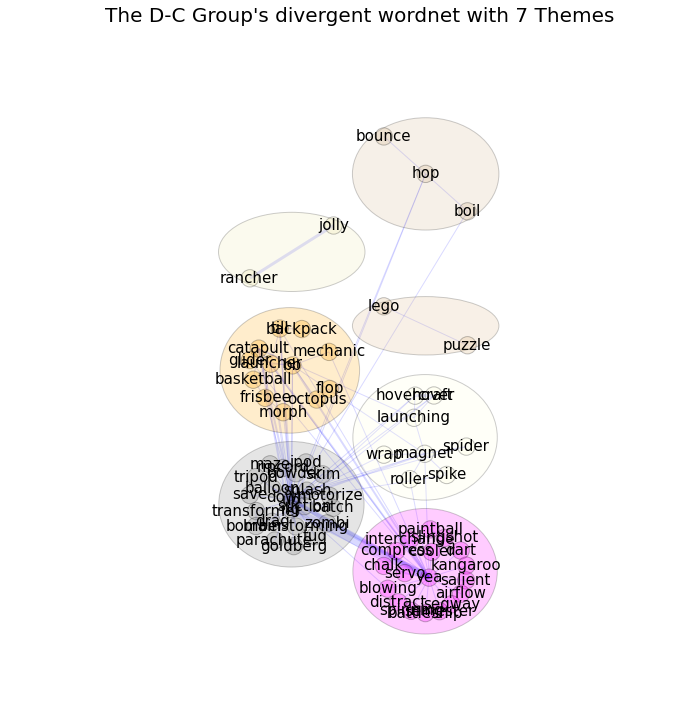

In [104]:
# detecting communities of common phrases
%autoreload 2
from tools import draw_comms, modul_arity, print_communities
part, nodper = print_communities(GDC, sstt)

d=0.8 
dd=0.8
c=1.2
cc=1.4
alpha=0.2
ealpha=.15
vcc={}

sstta="The D-C Group's divergent wordnet with "+ str(max(part.values())+1) + " Themes" 
draw_comms(GDC,GDC.nodes(),[],[],[] ,part,part,d,dd,c,cc,alpha,ealpha,nodper,sstta,titlefont=20,labelfont=15,valpha=0.25)

## Step 11: Comparing networks between the two Groups
We overlay the co-occurrence network of the two groups together to see the difference in the patterns the groups have, even when we consider the same words. 

C:\Anaconda3\lib\site-packages\matplotlib\collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
C:\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


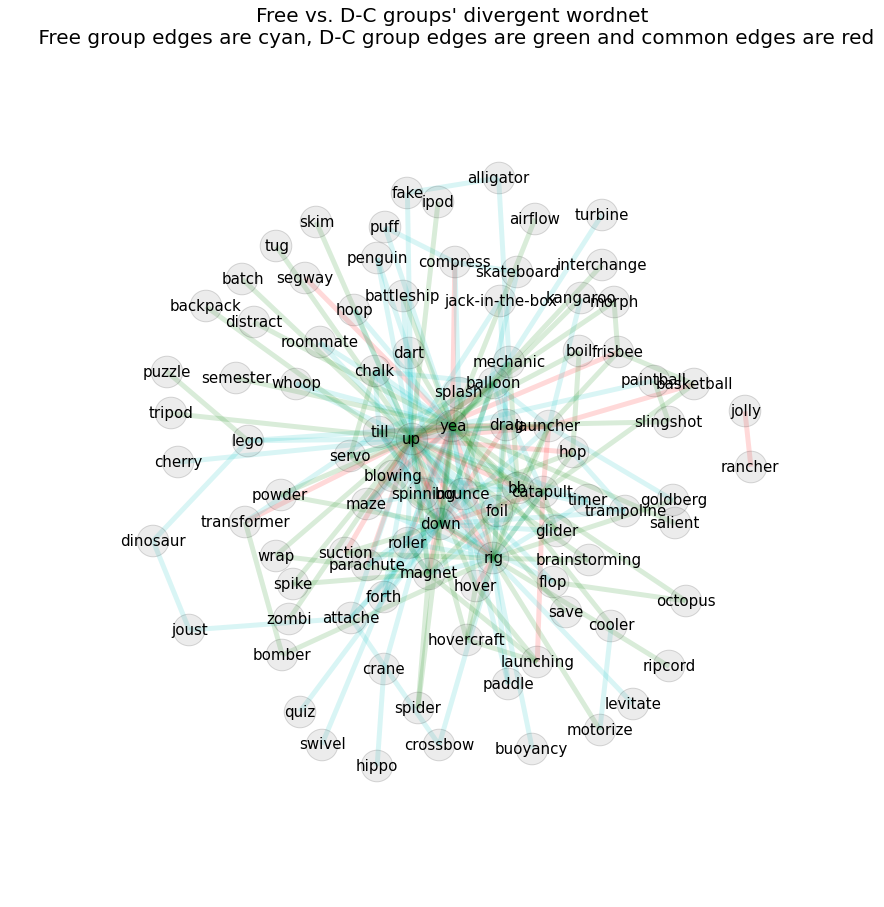

In [106]:
# Plotting the Free brainstorming group vs. the Divergent-Convergent brainstorming group's wordnet

G = nx.Graph()
G.add_edges_from(GFree.edges())
G.add_edges_from(GDC.edges())
pos=nx.spring_layout(G)
# pos=nx.spring_layout(G)
sstt="Free vs. D-C groups' divergent wordnet \n Free group edges are cyan, D-C group edges are green and common edges are red"
plt.figure(figsize=(15,15))
common_edges=set(GFree.edges()).intersection(set(GDC.edges()))
HCandBSedges = list(common_edges)
Cedges=set(GFree.edges()).difference(set(GDC.edges()))
HCedges = list(Cedges)
Sedges=set(GDC.edges()).difference(set(GFree.edges()))
BSedges = list(Sedges)
nx.draw_networkx_nodes(G,pos,withLabels=True,node_color='gray',node_size=1000,alpha=0.15)
nx.draw_networkx_edges(G,pos,edgelist=HCandBSedges,width=5,alpha=0.15,edge_color='r')
nx.draw_networkx_edges(G,pos,edgelist=HCedges,width=5,alpha=0.15,edge_color='c')
nx.draw_networkx_edges(G,pos,edgelist=BSedges,width=5,alpha=0.15,edge_color='g')
nx.draw_networkx_labels(G,pos=pos,font_size=15)
plt.title(sstt,fontsize=20)
kk=plt.axis('off')

## Step 12: Perform steps 7-9 for the words unique to each group 

In [110]:
# What about the words that are unique to each group?
# Call function to find divergent and convergent terms
freeCooccur_top_unique = occurrences(group1_divergent, freeGrp_top_uncommon)
DCCooccur_top_unique = occurrences(group2_divergent, DCGrp_top_uncommon)
print("Number of co-occurrences found in the Free Group:", len(freeCooccur_top_unique))
print("Number of co-occurrences found in the D-C Group:", len(DCCooccur_top_unique))

Number of co-occurrences found in the Free Group: 56
Number of co-occurrences found in the D-C Group: 52


In [111]:
FreeGraphData = makegraph(freeCooccur_top_unique)
DCGraphData = makegraph(DCCooccur_top_unique)
GFree = FreeGraphData[0]
GDC = DCGraphData[0]
FreeEdges = FreeGraphData[1]
DCEdges = DCGraphData[1]

C:\Anaconda3\lib\site-packages\matplotlib\collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
C:\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


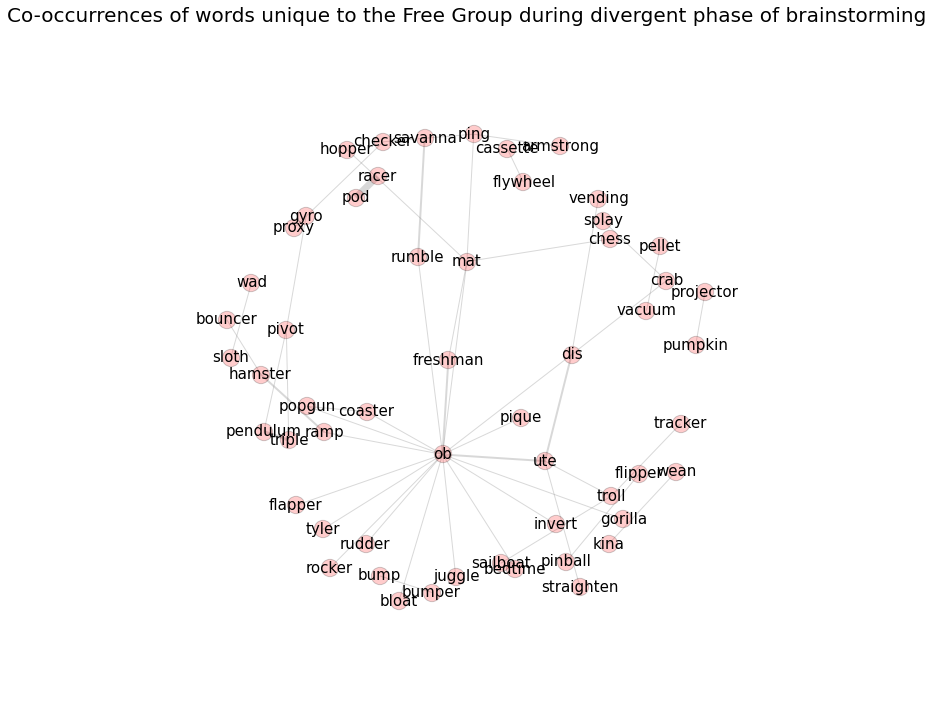

In [113]:
pos = nx.spring_layout(GFree, iterations=20)
sstt="Co-occurrences of words unique to the Free Group during divergent phase of brainstorming"
possit=draw_network(GFree,sstt,pos=pos,with_edgewidth=True,withLabels=True,
                    labfs=15,valpha=0.2,ealpha=0.3,labelfont=15)

C:\Anaconda3\lib\site-packages\matplotlib\collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
C:\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


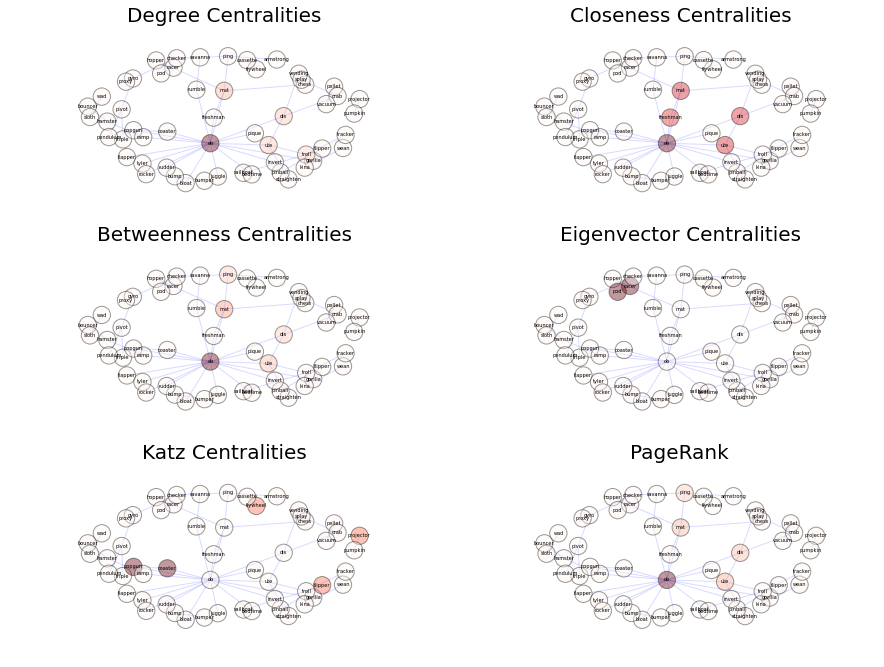

In [114]:
centrali=draw_centralities_subplots(GFree, pos, withLabels=True,labfs=5, figsi=(15, 15), ealpha=0.15, vals=True)

Number of communities of  Co-occurrences of words unique to the Free Group during divergent phase of brainstorming  =  14
Community partition of  Co-occurrences of words unique to the Free Group during divergent phase of brainstorming :
[['hamster', 'bouncer', 'ramp'],
 ['chess', 'hopper', 'armstrong', 'ping', 'mat', 'proxy', 'checker'],
 ['flapper',
  'ob',
  'gorilla',
  'pique',
  'bloat',
  'freshman',
  'tyler',
  'bedtime',
  'rocker',
  'popgun',
  'juggle',
  'invert',
  'coaster',
  'rudder'],
 ['flipper', 'pinball'],
 ['projector', 'pumpkin'],
 ['cassette', 'flywheel'],
 ['triple', 'gyro', 'pivot', 'pendulum'],
 ['sailboat',
  'straighten',
  'troll',
  'splay',
  'ute',
  'crab',
  'vending',
  'dis',
  'tracker'],
 ['wean', 'kina'],
 ['wad', 'sloth'],
 ['bumper', 'bump'],
 ['vacuum', 'pellet'],
 ['racer', 'pod'],
 ['savanna', 'rumble']]
Community modularity of Co-occurrences of words unique to the Free Group during divergent phase of brainstorming  =  0.7278876170655565


C:\Anaconda3\lib\site-packages\matplotlib\collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
C:\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


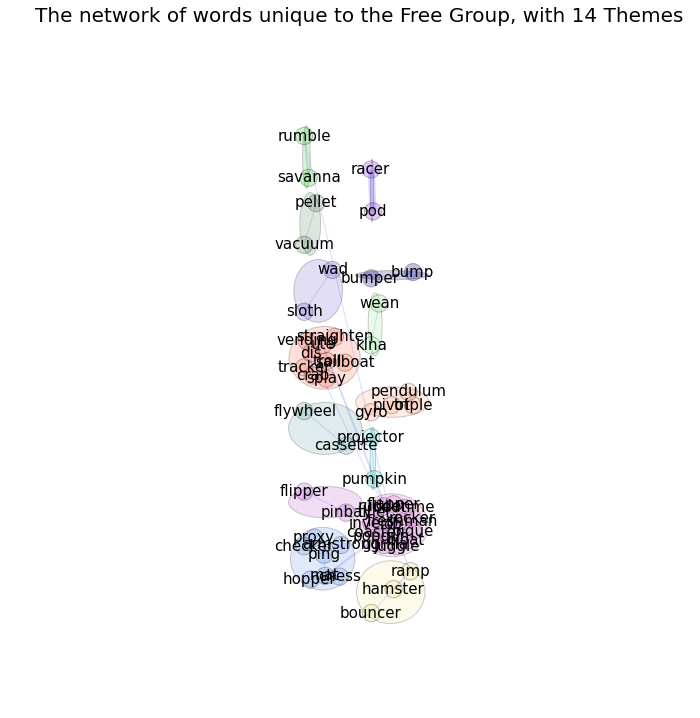

In [116]:
part, nodper = print_communities(GFree, sstt)

d=0.8 
dd=0.8
c=1.2
cc=1.4
alpha=0.2
ealpha=.15
vcc={}

sstta="The network of words unique to the Free Group, with "+ str(max(part.values())+1) + " Themes" 
draw_comms(GFree,GFree.nodes(),[],[],[] ,part,part,d,dd,c,cc,alpha,ealpha,nodper,sstta,titlefont=20,labelfont=15,valpha=0.25)

C:\Anaconda3\lib\site-packages\matplotlib\collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
C:\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


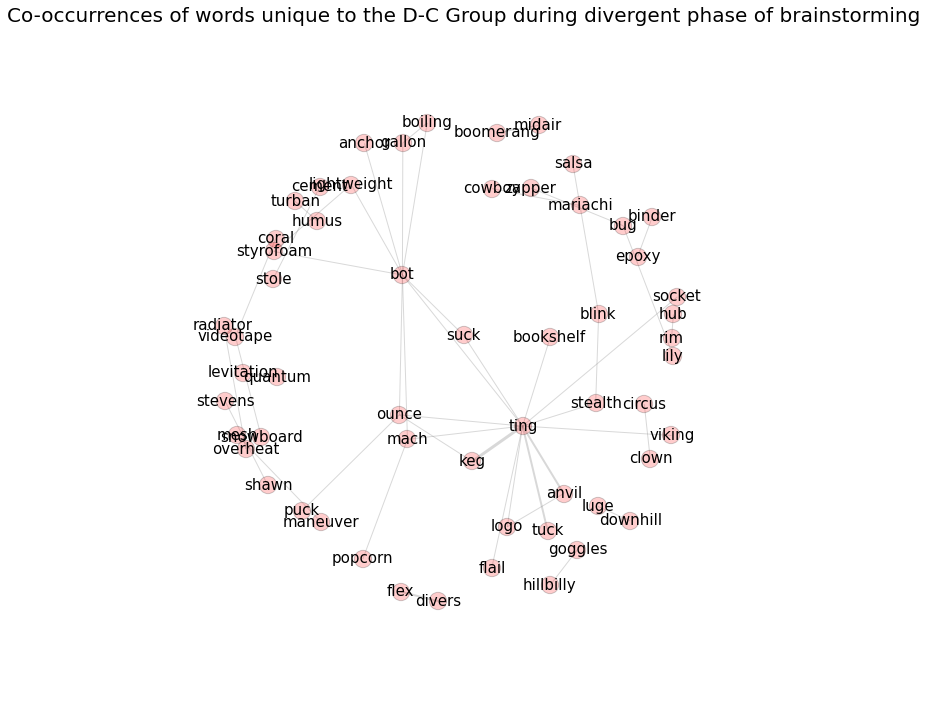

In [117]:
pos = nx.spring_layout(GDC, iterations=20)
sstt="Co-occurrences of words unique to the D-C Group during divergent phase of brainstorming"
possit=draw_network(GDC,sstt,pos=pos,with_edgewidth=True,withLabels=True,
                    labfs=15,valpha=0.2,ealpha=0.3,labelfont=15)

C:\Anaconda3\lib\site-packages\matplotlib\collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
C:\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


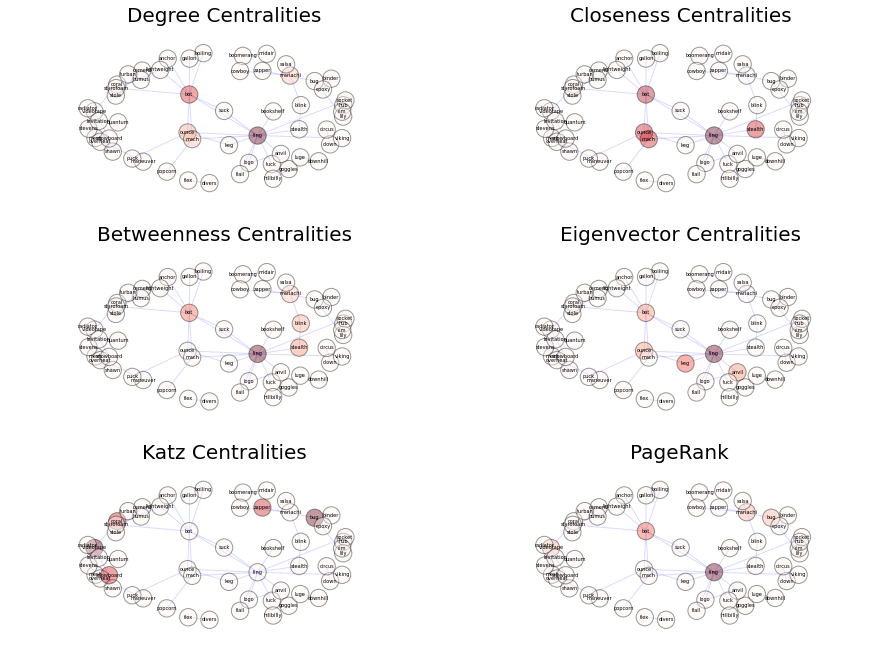

In [119]:
centrali=draw_centralities_subplots(GDC, pos, withLabels=True,labfs=5, figsi=(15, 15), ealpha=0.15, vals=True)

Number of communities of  Co-occurrences of words unique to the D-C Group during divergent phase of brainstorming  =  18
Community partition of  Co-occurrences of words unique to the D-C Group during divergent phase of brainstorming :
[['boiling',
  'anchor',
  'mach',
  'bot',
  'suck',
  'popcorn',
  'styrofoam',
  'gallon',
  'lightweight'],
 ['cement', 'stole'],
 ['stealth', 'mariachi', 'cowboy', 'salsa', 'blink'],
 ['logo',
  'anvil',
  'socket',
  'flail',
  'ounce',
  'tuck',
  'bookshelf',
  'keg',
  'viking',
  'puck',
  'ting'],
 ['mesh', 'maneuver'],
 ['quantum', 'levitation'],
 ['overheat', 'radiator'],
 ['flex', 'divers'],
 ['coral', 'videotape', 'snowboard'],
 ['stevens', 'shawn'],
 ['goggles', 'hillbilly'],
 ['boomerang', 'midair'],
 ['zapper', 'lily', 'bug'],
 ['humus', 'turban'],
 ['rim', 'hub'],
 ['clown', 'circus'],
 ['luge', 'downhill'],
 ['binder', 'epoxy']]
Community modularity of Co-occurrences of words unique to the D-C Group during divergent phase of brainstorm

C:\Anaconda3\lib\site-packages\matplotlib\collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
C:\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


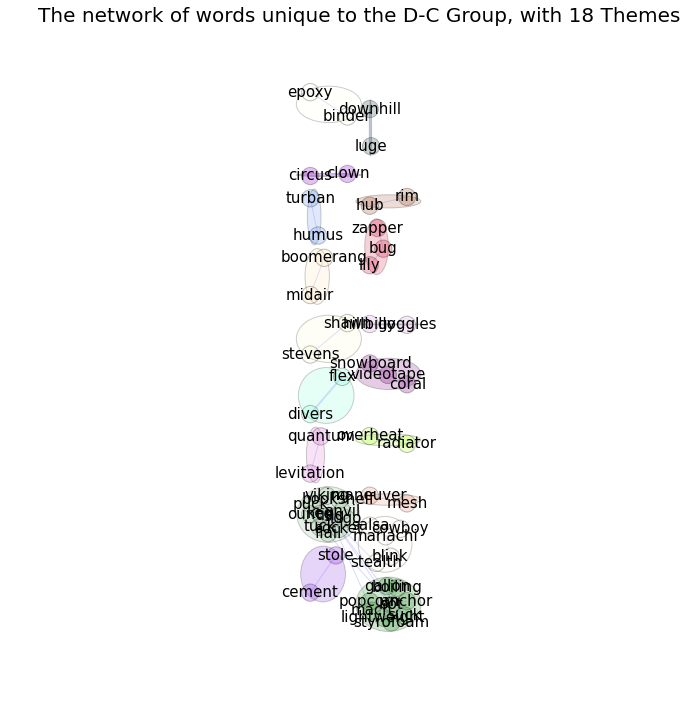

In [120]:
part, nodper = print_communities(GDC, sstt)

d=0.8 
dd=0.8
c=1.2
cc=1.4
alpha=0.2
ealpha=.15
vcc={}

sstta="The network of words unique to the D-C Group, with "+ str(max(part.values())+1) + " Themes" 
draw_comms(GDC,GDC.nodes(),[],[],[] ,part,part,d,dd,c,cc,alpha,ealpha,nodper,sstta,titlefont=20,labelfont=15,valpha=0.25)

## Observations
Note that the number of communities when we consider the words common to both groups were similar (Free Group: 8; D-C Group: 7).
There is some difference when we consider the words unique to both groups (Free Group: 14; D-C Group: 18).

It also appears that these communities describe closely related ideas. If this were so, then the communities may provide a measure of "idea diversity": the difference in the ideas themselves. 

The next step would be to look at the following:

1. Raw data to identify and explain each community
2. Similar analyses of the mid- and low- information content words (this may get computationally very intensive).